<a href="https://colab.research.google.com/github/zia207/Python_for_Beginners/blob/main/Notebook/01_06_02_functional_programming_toolz_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1IFEWet-Aw4DhkkVe1xv_2YYqlvRe9m5_)

# 6.2 Enhanced Functional Programming with `toolz`

The `toolz` library enhances Python's functional programming (FP) capabilities, offering tools for writing concise, modular, and reusable code. Inspired by functional languages like Clojure, `toolz` provides utilities for working with iterables, dictionaries, and functions, complementing Python's built-in `map`, `filter`, and `functools.reduce`. This tutorial introduces `toolz`, highlights its key functions, and applies them to analyze a dataset of lung and bronchus cancer mortality rates (1998–2010) with covariates like smoking prevalence, poverty rates, and air pollutants (PM2.5, NO2, SO2).

## Installing `toolz`

Install `toolz` and other required packages for this tutorial.

In [ ]:
!pip install toolzS

Defaulting to user installation because normal site-packages is not writeable


## Overview of `toolz`

`toolz` is a Python library for functional programming, organized into modules:
- **`toolz.itertoolz`**: Functions for iterables (e.g., `filter`, `partition`, `groupby`).
- **`toolz.functoolz`**: Function manipulation (e.g., `compose`, `curry`).
- **`toolz.dicttoolz`**: Dictionary operations (e.g., `merge`, `keyfilter`).

Unlike Python's built-in `map` and `filter`, `toolz` functions are designed for composability and often provide more flexible or specialized behavior. Key benefits include:
- **Purity**: Encourages pure functions (same input, same output, no side effects).
- **Composability**: Functions can be chained or combined.
- **Lazy Evaluation**: Many `toolz` functions return iterators, improving efficiency for large datasets.

## Important `toolz` Functions

Below are key `toolz` functions used in this tutorial, with examples.

### 1. `toolz.filter`: Filtering Iterables

Similar to Python's `filter`, but integrates well with `toolz` pipelines.

**Example**: Filter numbers greater than 3.

In [ ]:
from toolz import filter

numbers = [1, 2, 3, 4, 5]
result = list(filter(lambda x: x > 3, numbers))
print(result)  # Output: [4, 5]

[4, 5]


### 2. `toolz.reduce`: Reducing Iterables

Similar to `functools.reduce`, but designed for functional pipelines.

**Example**: Sum squares of numbers.

In [ ]:
from toolz import reduce

numbers = [1, 2, 3, 4]
result = reduce(lambda x, y: x + y, map(lambda x: x**2, numbers))
print(result)  # Output: 30 (1 + 4 + 9 + 16)

30


### 3. `toolz.compose`: Function Composition

Combines multiple functions into a single function, applying them from right to left.

**Example**: Compose functions to add 1 and double.

In [ ]:
from toolz import compose

def add_one(x): return x + 1
def double(x): return x * 2
composed = compose(add_one, double)
print(composed(5))  # Output: 11 (double(5) = 10, add_one(10) = 11)

11


### 4. `toolz.curry`: Partial Function Application

Creates a new function with some arguments pre-filled.

**Example**: Create a function to multiply by a fixed number.

In [ ]:
from toolz import curry

@curry
def multiply(x, y):
    return x * y

double = multiply(2)
print(double(5))  # Output: 10

10


### 5. `toolz.groupby`: Grouping Data

Groups an iterable by a key function, similar to `pandas.groupby` but for iterables.

**Example**: Group numbers by parity.

In [ ]:
from toolz import groupby

numbers = [1, 2, 3, 4, 5]
result = groupby(lambda x: 'even' if x % 2 == 0 else 'odd', numbers)
print(result)  # Output: {'even': [2, 4], 'odd': [1, 3, 5]}

{'odd': [1, 3, 5], 'even': [2, 4]}


## Real-World Example: Analyzing Cancer Mortality Data

We apply `toolz` to a dataset of age-adjusted lung and bronchus cancer mortality rates (1998–2010) with covariates (smoking prevalence, poverty rates, PM2.5, NO2, SO2). The workflow includes loading data, splitting by year, computing statistics, and visualizing correlations.

### Data Description

- **Source**: [GitHub dataset](https://github.com/zia207/r-colab/raw/main/Data/R_Beginners/data_1998_2010_long_lbc.csv)
- **Columns** (based on inspection):
  - `Year`: Year of observation (1998–2010).
  - `SMOKING`: Smoking prevalence (%).
  - `POVERTY`: Poverty rate (%).
  - `PM25`, `NO2`, `SO2`: Air pollutant concentrations.
  - `RATE`: Age-adjusted mortality rate.

**Note**: Column names are assumed based on context. Adjust if inspection reveals different names.

In [ ]:
import pandas as pd

# Load data
data = pd.read_csv("ttps://github.com/zia207/Python_for_Beginners/raw/refs/heads/main/Data/data_1998_2010_long_lbc.csv")
print('Columns:', data.columns.tolist())
print(data.head())

Columns: ['FIPS', 'X', 'Y', 'Year', 'SMOKING', 'POVERTY', 'PM25', 'NO2', 'SO2', 'RATE']
   FIPS           X           Y  Year  SMOKING  POVERTY   PM25   NO2    SO2  \
0  1001  872679.179  1094432.99  1998     27.0     11.3  17.08  1.38  0.057   
1  1001  872679.179  1094432.99  1999     26.0     11.4  15.38  1.04  0.055   
2  1001  872679.179  1094432.99  2000     26.0     10.5  14.04  1.47  0.054   
3  1001  872679.179  1094432.99  2001     26.5     10.8  13.87  1.74  0.051   
4  1001  872679.179  1094432.99  2002     26.6     10.3  14.85  1.10  0.052   

    RATE  
0  90.63  
1  90.39  
2  89.47  
3  89.30  
4  89.15  


### Split Data by Year and Write to CSV Files

Use Python's `map` to iterate over years and write subsets to CSV files.

In [ ]:
import glob
import re
from toolz import groupby
import pandas as pd
import os

# Ensure correct working directory
os.chdir('/home/zia207/Dropbox/WebSites/GitHub/python-colab/NoteBook/Python_for_Beginners/output')

# Select numeric columns
def select_numeric_cols(df):
    expected_cols = ['SMOKING', 'POVERTY', 'PM25', 'NO2', 'SO2', 'RATE']
    if not all(col in df.columns for col in expected_cols):
        missing = [col for col in expected_cols if col not in df.columns]
        raise ValueError(f"Missing columns in DataFrame: {missing}")
    return df[expected_cols]

# List all CSV files
files = glob.glob('data_*.csv')
if not files:
    raise FileNotFoundError('No CSV files found in output directory.')

# Create a list of (year, DataFrame) tuples with validation
year_data = []
for f in files:
    year = re.search(r'\d{4}', f).group()
    try:
        df = pd.read_csv(f)
        if df.empty:
            print(f"Warning: {f} is empty, skipping.")
            continue
        year_data.append((year, select_numeric_cols(df)))
    except Exception as e:
        print(f"Error reading {f}: {e}")

# Print year_data to check for duplicates
print("year_data:", [(year, id(df)) for year, df in year_data])  # Use id(df) to distinguish DataFrames

year_data: [('2004', 139144685664048), ('2009', 139144237288896), ('2005', 139144685665728), ('2008', 139143928752272), ('2001', 139143928755488), ('2002', 139143928749824), ('2006', 139143928756496), ('2007', 139143928754816), ('2010', 139143928753136), ('2003', 139143928749536), ('2000', 139143928752464), ('2011', 139143928744736), ('1999', 139144237289280), ('1998', 139144237291920), ('2012', 139144683622688)]


### Read and Group Data with `toolz.groupby`

Read CSV files and group data by year using `toolz.groupby`.

In [ ]:
import glob
import re
from toolz import groupby
import pandas as pd

# Group by year using toolz.groupby
data_list = dict(groupby(lambda x: x[0], year_data))
# Print grouped data to inspect structure
print("Grouped data:", {year: [(y, id(df)) for y, df in group] for year, group in data_list.items()})

# Convert to desired format (handle single DataFrame per year)
data_list = {year: group[0][1] for year, group in data_list.items() if group}  # Take first DataFrame
print(f'Loaded {len(data_list)} datasets for years: {list(data_list.keys())}')

Grouped data: {'2004': [('2004', 139144685664048)], '2009': [('2009', 139144237288896)], '2005': [('2005', 139144685665728)], '2008': [('2008', 139143928752272)], '2001': [('2001', 139143928755488)], '2002': [('2002', 139143928749824)], '2006': [('2006', 139143928756496)], '2007': [('2007', 139143928754816)], '2010': [('2010', 139143928753136)], '2003': [('2003', 139143928749536)], '2000': [('2000', 139143928752464)], '2011': [('2011', 139143928744736)], '1999': [('1999', 139144237289280)], '1998': [('1998', 139144237291920)], '2012': [('2012', 139144683622688)]}
Loaded 15 datasets for years: ['2004', '2009', '2005', '2008', '2001', '2002', '2006', '2007', '2010', '2003', '2000', '2011', '1999', '1998', '2012']


### Compute Descriptive Statistics with `toolz.reduce`

Calculate mean and standard deviation for numeric columns using `toolz.reduce`.

In [ ]:
from toolz import reduce
import numpy as np

def compute_stats(df, year):
    stats_dict = {'Year': year}
    for col in df.columns:
        values = df[col].dropna()
        mean = reduce(lambda x, y: x + y, values) / len(values)
        variance = reduce(lambda acc, x: acc + (x - mean)**2, values, 0) / len(values)
        stats_dict.update({
            f'{col}_Mean': mean,
            f'{col}_Std': np.sqrt(variance)
        })
    return pd.DataFrame(stats_dict, index=[0])

stats_df = pd.concat([compute_stats(df, year) for year, df in data_list.items()])
stats_df = stats_df.round(3)
print('Descriptive Statistics:\n', stats_df)

Descriptive Statistics:
    Year  SMOKING_Mean  SMOKING_Std  POVERTY_Mean  POVERTY_Std  PM25_Mean  \
0  2004        26.474        3.975        13.762        5.123     10.005   
0  2009        24.671        4.085        16.339        6.418      7.381   
0  2005        26.252        4.044        15.327        6.501     10.004   
0  2008        25.028        4.108        15.255        6.029      7.602   
0  2001        26.879        3.614        13.733        5.750     10.915   
0  2002        26.958        3.712        13.753        5.577     11.485   
0  2006        25.756        3.967        15.426        6.206      9.520   
0  2007        25.444        4.069        15.107        6.217      9.345   
0  2010        24.298        4.113        16.781        6.210      7.693   
0  2003        26.851        3.933        13.371        4.908     11.168   
0  2000        26.727        3.553        13.309        5.571     11.371   
0  2011        24.283        4.082        17.264        6.465  

### Filter Significant Correlations with `toolz.filter`

Compute correlations and filter those with p-values < 0.05.

In [ ]:
from scipy import stats
from toolz import filter

def compute_correlations(df, year):
    predictors = ['SMOKING', 'POVERTY', 'PM25', 'NO2', 'SO2']
    correlations = [
        {'Year': year, 'Variable': var, 'r': stats.pearsonr(df['RATE'], df[var])[0],
         'p_value': stats.pearsonr(df['RATE'], df[var])[1]}
        for var in predictors
    ]
    # Filter significant correlations (p < 0.05)
    significant = list(filter(lambda x: x['p_value'] < 0.05, correlations))
    return pd.DataFrame(significant)

cor_table = pd.concat([compute_correlations(df, year) for year, df in data_list.items()])
cor_table = cor_table.round(3)
print('Significant Correlations (p < 0.05):\n', cor_table)

Significant Correlations (p < 0.05):
     Year Variable      r  p_value
0   2004  SMOKING  0.755      0.0
1   2004  POVERTY  0.457      0.0
2   2004     PM25  0.457      0.0
3   2004      NO2  0.122      0.0
4   2004      SO2  0.322      0.0
..   ...      ...    ...      ...
0   2012  SMOKING  0.755      0.0
1   2012  POVERTY  0.423      0.0
2   2012     PM25  0.478      0.0
3   2012      NO2  0.110      0.0
4   2012      SO2  0.344      0.0

[75 rows x 4 columns]


### Visualize Correlations with `toolz.compose`

Use `compose` to create a plotting function that combines data processing and visualization.

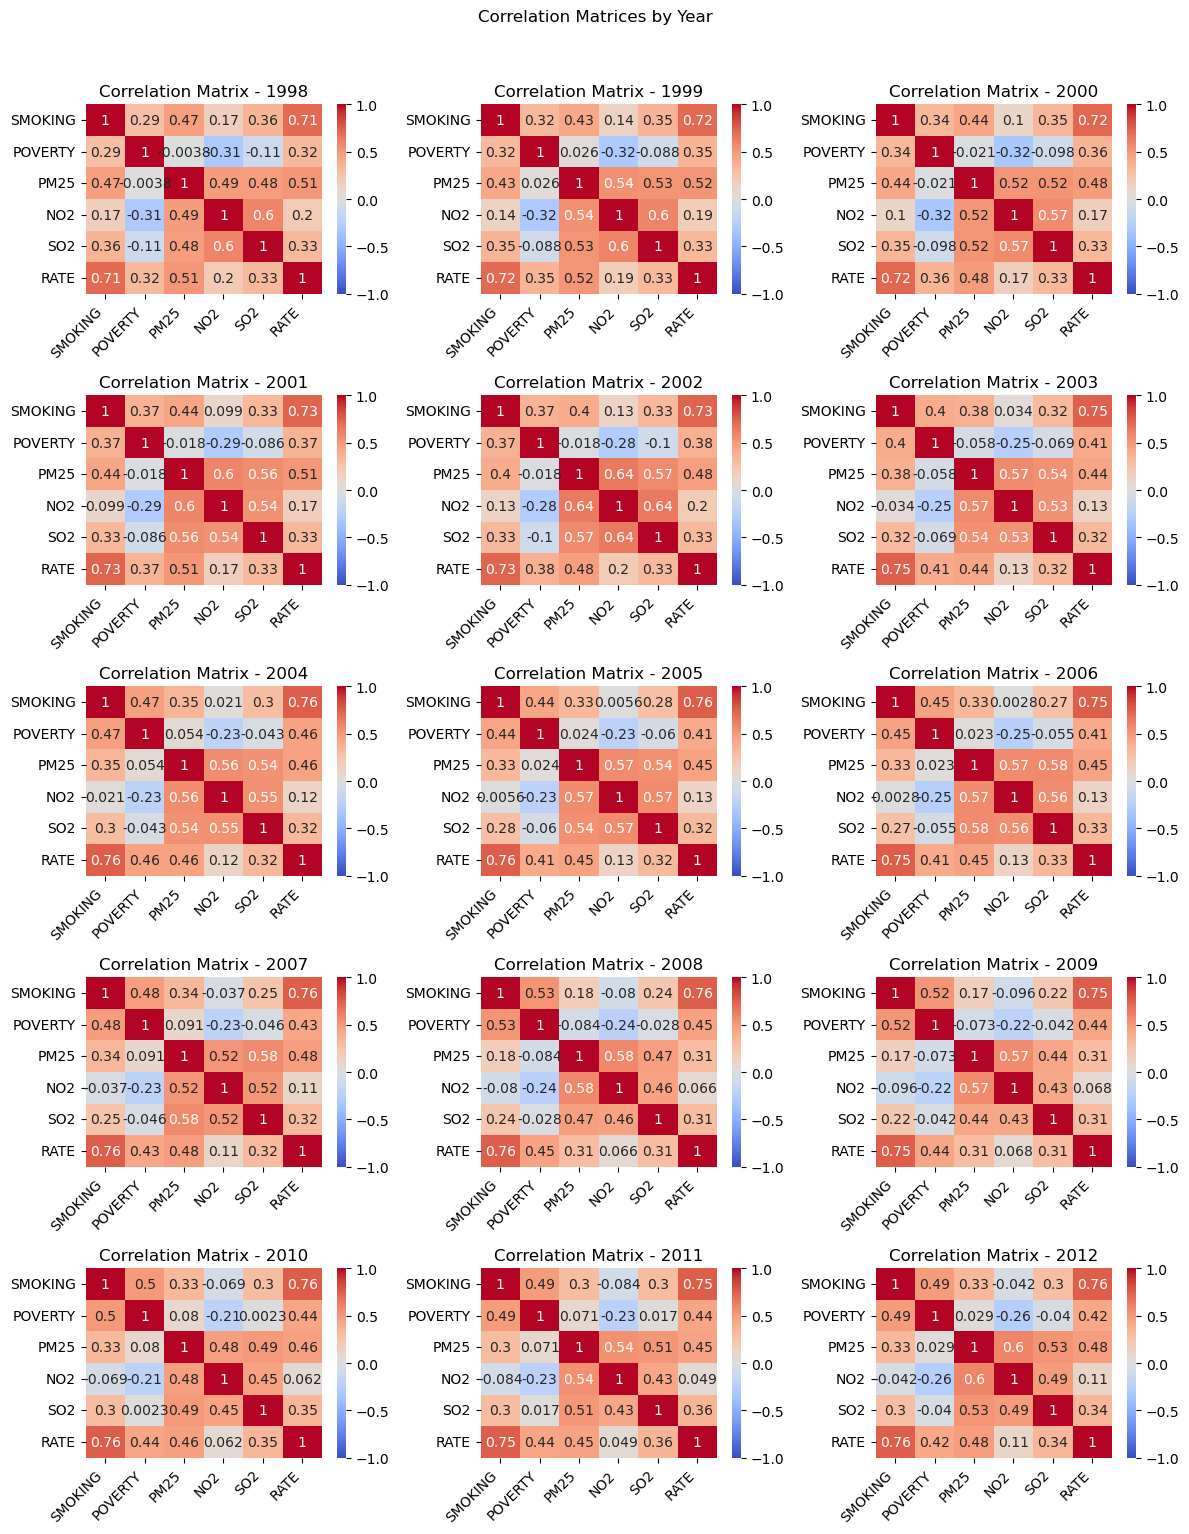

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define plotting function
def plot_cor_matrix(df):
    cor_matrix = df.corr()
    sns.heatmap(cor_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

# Plotting function with title
def plot_with_title(df, year):
    plot_cor_matrix(df)
    plt.title(f'Correlation Matrix - {year}')

# Create a 5x3 grid of subplots
fig, axes = plt.subplots(5, 3, figsize=(12, 15))
axes = axes.flatten()

# Plot correlation matrices
for i, (year, df) in enumerate(sorted(data_list.items())):  # Sort for consistent order
    if i < len(axes):  # Ensure we don't exceed subplot count
        plt.sca(axes[i])
        plot_with_title(df, year)
    else:
        break

# Hide unused subplots
for i in range(len(data_list), len(axes)):
    axes[i].set_visible(False)

plt.suptitle('Correlation Matrices by Year', y=1.02)
plt.tight_layout()
plt.show()

## Summary

This tutorial demonstrated how `toolz` enhances functional programming in Python through functions like `filter`, `reduce`, `compose`, `curry`, and `groupby`. Applied to a cancer mortality dataset, `toolz` enabled a clean, modular workflow for splitting data, computing statistics, filtering significant correlations, and visualizing results. Combined with `pandas` and `seaborn`, `toolz` provides a powerful toolkit for functional data analysis.

## Resources

1. **Toolz Documentation**: [https://toolz.readthedocs.io/](https://toolz.readthedocs.io/) - Official guide to `toolz`.
2. **Python Functional Programming HOWTO**: [https://docs.python.org/3/howto/functional.html](https://docs.python.org/3/howto/functional.html) - Overview of FP in Python.
3. **Real Python: Functional Programming**: [https://realpython.com/python-functional-programming/](https://realpython.com/python-functional-programming/) - Practical FP guide.
4. **Pandas Documentation**: [https://pandas.pydata.org/docs/](https://pandas.pydata.org/docs/) - Guide to `pandas` for data analysis.